# Week 9 - Beyond Text

This week, we "trascend" text to explore analysis of sound and visual content. Trillions of digital audio, image, and video files have been generated by cell phones and distributed sensors, preserved and shared through social medial, the web, private and government administrations. In this notebook, we read in and visualize audio and image files, process them to extract relevant features and measurement, then begin to explore how to analyze and extract information from them through the same approaches to supervised and unsupervised learning we have performed thoughout the quarter with text.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import scipy #For frequency analysis
import scipy.fftpack
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import IPython #To show stuff

#Image handling install as Pillow
import PIL
import PIL.ImageOps

#install as scikit-image, this does the image manupulation
import skimage
import skimage.feature
import skimage.segmentation
import skimage.filters
import skimage.color
import skimage.graph
import skimage.future.graph

#these three do audio handling
import pydub #Requires ffmpeg to be installed https://www.ffmpeg.org/download.html; on a mac "brew install ffmpeg"
import speech_recognition #install as speechrecognition
import soundfile #Install as pysoundfile 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning it may generate.
%matplotlib inline

import os
import os.path
import csv
import re


C:\Users\acmel\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that read in 10 audio files (e.g., produced on your smartphone recorder?) from at least two different speakers, which include sentences of different types (e.g., question, statement, exclamation). At least two of these should include recordings of the two speakers talking to each other (e.g., a simple question/answer). Contrast the frequency distributions of the words spoken within speaker. What speaker's voice has a higher and which has lower frequency? What words are spoken at the highest and lowest frequencies? What parts-of-speech tend to be high or low? How do different types of sentences vary in their frequency differently? When people are speaking to each other, how do their frequencies change? Whose changes more?

In [2]:
wavPath = r"C:\Users\acmel\Anaconda3\Content-Analysis-2020\week-9\SBC034.wav"
soundArr, soundSampleRate = soundfile.read(wavPath)
soundArr.shape

(32643813, 2)

In [3]:
soundSampleRate

22050

In [4]:
numS = soundArr.shape[0] // soundSampleRate
print("The sample is {} seconds long".format(numS))
print("Or {:.2f} minutes".format(numS / 60))

The sample is 1480 seconds long
Or 24.67 minutes


In [5]:
numS = soundArr.shape[0] // soundSampleRate
print("The sample is {} seconds long".format(numS))
print("Or {:.2f} minutes".format(numS / 60))

The sample is 1480 seconds long
Or 24.67 minutes


In [6]:
from pydub import AudioSegment
from pydub.utils import make_chunks

myaudio = AudioSegment.from_file(r"C:\\Users\\acmel\\Anaconda3\\Content-Analysis-2020\\week-9\\SBC034.wav" , "wav") 
chunk_length_ms = 144000 # 2.4mins in milliseconds
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of 2.4mins or shorter

#Export all of the individual chunks as wav files

for i, chunk in enumerate(chunks):
    chunk_name = "SBC034-{0}.wav".format(i)
    print ("exporting", chunk_name)
    chunk.export(chunk_name, format="wav")

exporting SBC034-0.wav
exporting SBC034-1.wav
exporting SBC034-2.wav
exporting SBC034-3.wav
exporting SBC034-4.wav
exporting SBC034-5.wav
exporting SBC034-6.wav
exporting SBC034-7.wav
exporting SBC034-8.wav
exporting SBC034-9.wav
exporting SBC034-10.wav


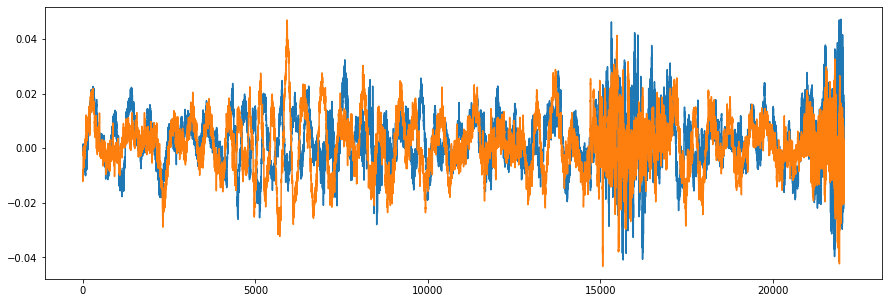

In [7]:
#first 1sec of audio
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(soundArr[:soundSampleRate])
plt.show()

In [8]:
soundArr.shape

(32643813, 2)

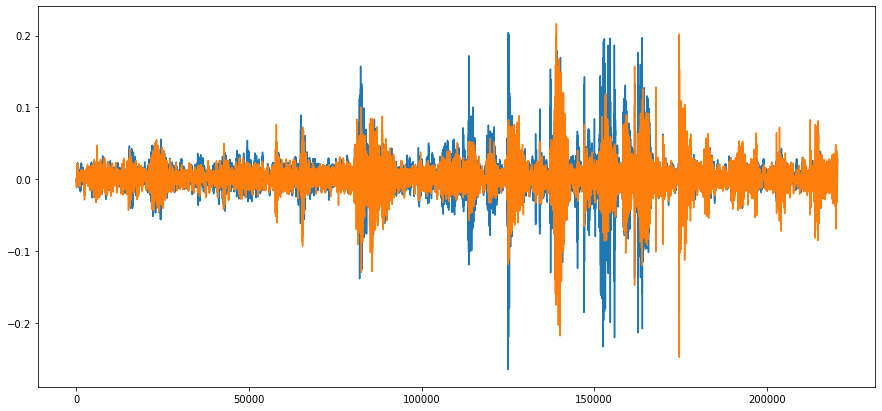

In [9]:
#first 10sec of audio
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate * 10])
plt.show()

In [21]:
transcriptPath = "../data/SBC034.trn"

In [32]:
def loadTranscript(targetFile):
    #Regex because the transcripts aren't consistent enough to use csv
    regex = re.compile(r"(\d+\.\d+)\s(\d+\.\d+)\s(.+:)?\s+(.*)")
    dfDict = {
        'time_start' : [],
        'time_end' : [],
        'speaker' : [],
        'text' : [],

    }
    with open(targetFile, encoding='latin-1') as f:
        for line in f:
            r = re.match(regex, line)
        
            dfDict['time_start'].append(float(r.group(1)))
            dfDict['time_end'].append(float(r.group(2)))
            if r.group(3) is None:
                dfDict['speaker'].append(dfDict['speaker'][-1])
            else:
                dfDict['speaker'].append(r.group(3))
            dfDict['text'].append(r.group(4))
    
    return pandas.DataFrame(dfDict)
    
transcriptDF = loadTranscript(transcriptPath)
transcriptDF[:10]

AttributeError: 'NoneType' object has no attribute 'group'

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that use the 10 audio files from at least two different speakers read in previously, attempt to automatically extract the words from Google, and calculate the word-error rate, as descibed in Chapter 9 from *Jurafsky & Martin*, page 334. How well does it do? Under what circumstances does it perform poorly? 

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that read in 10 image files (e.g., produced on your smartphone, harvested from the web, etc.) that feature different kinds of objects and settings, including at least one indoor and one outdoor setting. Perform blob detection and RAG segmentation using the approaches modeled above. How well does each algorithm identify objects or features of interest?

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">You can either:
    
a) Construct cells immediately below this that report the results from experiments in which you place each of images taken or retrieved for the last exercise through the online demos for [caffe](http://demo.caffe.berkeleyvision.org) and [places](http://places.csail.mit.edu/demo.html). Paste the image and the output for both object detector and scene classifier below, beside one another. Calculate precision and recall for caffe's ability to detect objects of interest across your images. What do you think about Places' scene categories and their assignments to your images? 
    
b) Implement any one deep learning example using PyTorch and images.

Could you use image classification to enhance your research project and, if so, how?